#NEW YORK airbnb flats

In [2]:
!pip install osmnx

     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 10.3MB 12.3MB/s 
     |████████████████████████████████| 1.0MB 39.8MB/s 
     |████████████████████████████████| 6.5MB 68.2MB/s 
     |████████████████████████████████| 1.0MB 59.9MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 15.3MB 341kB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [1]:
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

###Загружаем граф географической области

In [2]:
G = ox.graph_from_place('Manhattan, New York, USA', network_type='walk')

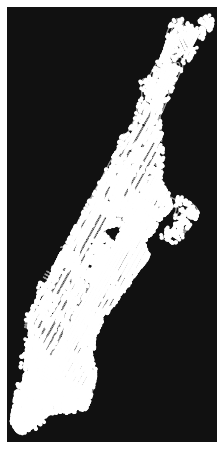

In [3]:
fig, ax = ox.plot_graph(G,)

###Загружаем датасет

In [4]:
data = pd.read_csv('drive/MyDrive/dataset/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


###Анализ данных

In [5]:
# типы недвижимости, которую можно арендовать
data['room_type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [6]:
# районы NY
data['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

Text(0.5, 0, 'Data')

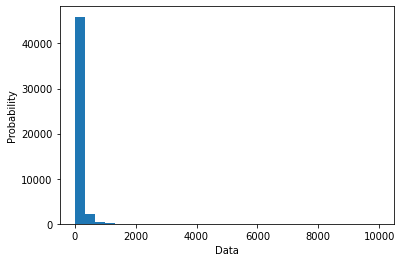

In [7]:
# посмотрим на распределение стоимости аренды
prices = data['price'].values
plt.hist(prices, bins=30)
plt.ylabel('Probability')
plt.xlabel('Data')

In [8]:
# квантиль 0.99 от цены
data['price'].quantile(.99)

799.0

In [9]:
# избавимся от ценовых выбросов
data = data[data['price']<data['price'].quantile(.99)]

Text(0.5, 0, 'Data')

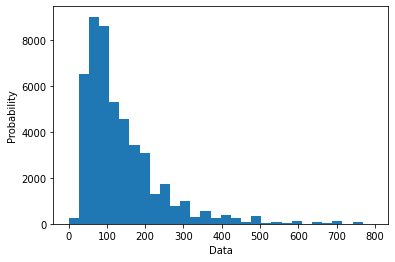

In [10]:
# посмотрим на распределение еще раз стоимости аренды
prices = data['price'].values
plt.hist(prices, bins=30)
plt.ylabel('Probability')
plt.xlabel('Data')

In [11]:
# средняя цена объекта недвижимости
data['price'].mean()

137.29793607834225

In [12]:
# квантиль 0.2 от цены
data['price'].quantile(.2)

60.0

In [13]:
# оставим только дешевые варианты
data = data[data['price']<data['price'].quantile(.2)]

In [14]:
len(data)

8605

In [15]:
# аренда нужна на 1-2 дня
data = data[data['minimum_nights']<3]

In [16]:
len(data)

4627

In [17]:
# хорошо бы, чтобы объект был достаточно популярный
data['number_of_reviews'].mean()

30.18781067646423

In [18]:
data = data[data['number_of_reviews']>data['number_of_reviews'].mean()]

In [19]:
len(data)

1270

In [20]:
# исключаем апартаменты и общие комнаты
data = data[data['room_type'] == 'Private room']

In [21]:
# доступна в большинство календарных дней
data = data[data['availability_365'] > 300]

In [22]:
# район Manhattan
data = data[data['neighbourhood_group'] == 'Manhattan']

In [23]:
len(data)

18

###Найдем объект ближайший по расположению к Empire State Building

In [24]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://bashni.info/wp-content/uploads/2018/05/Sunset-at-the-Empire-State.jpg")

In [25]:
latitude = data['latitude'].values
longitude = data['longitude'].values

In [26]:
latitude

array([40.83403, 40.82264, 40.82124, 40.85933, 40.80759, 40.80732,
       40.80617, 40.79637, 40.82153, 40.80749, 40.87157, 40.85256,
       40.87133, 40.83018, 40.80039, 40.80715, 40.81609, 40.8068 ])

In [27]:
# Координаты ESB
latitude_ESB = 40.748391
longtitude_ESB = -73.985543

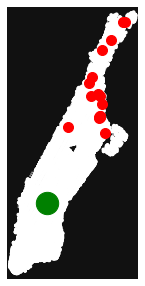

In [30]:
# Посмотрит на объекты на карте
fig, ax = ox.plot_graph(G,figsize=(5,5),show=False, close=False)
ax.scatter(longitude,latitude,  c='red', s=100)#, alpha=0.3)
ax.scatter(longtitude_ESB,latitude_ESB,  c='green', s=500)#, alpha=0.3)
plt.show()

In [35]:
# Найдем вершину графа G, ближайшую к ESB
ESB_point = latitude_ESB, longtitude_ESB
nearest_edge_ESB = ox.get_nearest_edge(G, ESB_point)

In [36]:
nearest_edge_ESB

(7782216998, 7782217001, 0)

In [37]:
# Найдем вершины графа G, ближайшие к объектам
nearest_edges = ox.get_nearest_edges(G, longitude, latitude)

In [38]:
# Всего вершин
len(list(G))

28599

###Нарисуем один путь

In [39]:
route = nx.shortest_path(G, nearest_edge_ESB[0], nearest_edges[0][0])

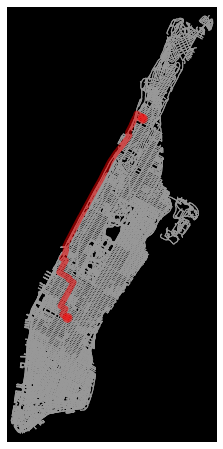

In [40]:
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

###Измерим один путь

In [41]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [42]:
route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))
route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')))

In [43]:
print('Route  is', route_length, 'meters and takes', route_time, 'seconds.')

Route  is 12402 meters and takes 1003 seconds.


###Теперь измерим по всем объектам

In [44]:
route_lengths = []
route_times = []
for i in range(len(latitude)):
    route = nx.shortest_path(G, nearest_edge_ESB[0], nearest_edges[i][0])
    route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))
    route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')))
    route_lengths.append(route_length)
    route_times.append(route_time)

    print('Route  is', route_length, 'meters and takes', route_time, 'seconds.')

Route  is 12402 meters and takes 1003 seconds.
Route  is 11939 meters and takes 1005 seconds.
Route  is 12284 meters and takes 1037 seconds.
Route  is 17519 meters and takes 1387 seconds.
Route  is 10871 meters and takes 998 seconds.
Route  is 10950 meters and takes 1006 seconds.
Route  is 10712 meters and takes 983 seconds.
Route  is 11055 meters and takes 1020 seconds.
Route  is 11472 meters and takes 963 seconds.
Route  is 10729 meters and takes 986 seconds.
Route  is 17474 meters and takes 1412 seconds.
Route  is 14941 meters and takes 1206 seconds.
Route  is 17760 meters and takes 1444 seconds.
Route  is 11629 meters and takes 945 seconds.
Route  is 8560 meters and takes 791 seconds.
Route  is 10729 meters and takes 986 seconds.
Route  is 12671 meters and takes 1073 seconds.
Route  is 10792 meters and takes 991 seconds.


In [45]:
np.argmin(route_times)

14

In [46]:
my_choice = data.iloc[np.argmin(route_times)]
print(my_choice)

id                                                                       15246070
name                              Lovely&Morden bedroom near everything you want!
host_id                                                                  33064599
host_name                                                                   Yukee
neighbourhood_group                                                     Manhattan
neighbourhood                                                     Upper West Side
latitude                                                                  40.8004
longitude                                                                -73.9672
room_type                                                            Private room
price                                                                          49
minimum_nights                                                                  1
number_of_reviews                                                              56
last_review     

In [47]:
print(my_choice['latitude'], my_choice['longitude'])

40.80039 -73.96724


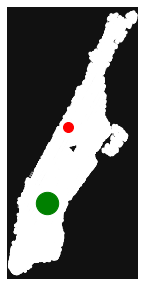

In [50]:
fig, ax = ox.plot_graph(G, figsize=(5,5), show=False, close=False)
ax.scatter(my_choice['longitude'],my_choice['latitude'],  c='red', s=100)
ax.scatter(longtitude_ESB,latitude_ESB,  c='green', s=500)
plt.show()